In [1]:
import torch
from torch_geometric.data import Data

/Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/typing.py:53: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN2at4_ops11randint_low4callExxN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEE
  Referenced from: <2C1A977F-6828-3F8B-9F81-0DA5668C2B45> /Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/libpyg.so
  Expected in:     <FAE346CA-DD75-315A-9B63-62D89C507026> /Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/typing.py:98: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: dlopen(/Users/islambendaoud/opt/anaco

# Création d'un graphe

**Question** Créer un objet de class `Data` qui représente un petit graphe de 3 noeuds 0, 1, et 2 et étiquetés (ce sont les attributs) -1, 0, 1 et dont les arêtes sont

- de 0 vers 1 dans les deux sens, 
- de 1 vers 2 dans les deux sens. 

In [2]:
# arêtes
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
# attributs
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [3]:
data

Data(x=[3, 1], edge_index=[2, 4])

**Question** Afficher les infos suivantes : 
```
nb noeuds :  3 
nb arêtes :  4 
nb attributs noeuds : 1 
nb attributs arêtes : 0 
noeuds isolés : False 
self loops : False 
dirigé : False
```

In [4]:
print("nb noeuds : ", data.num_nodes ,
      "\nnb arêtes : ", data.num_edges, 
      "\nnb attributs noeuds :", data.num_node_features, 
      "\nnb attributs arêtes :", data.num_edge_features,
      "\nnoeuds isolés :", data.has_isolated_nodes(),
      "\nself loops :", data.has_self_loops(), "\ndirigé :",data.is_directed())

nb noeuds :  3 
nb arêtes :  4 
nb attributs noeuds : 1 
nb attributs arêtes : 0 
noeuds isolés : False 
self loops : False 
dirigé : False


# Un jeu de données de plusieurs graphes

**Question** Importer le jeu de données ENZYMES. On conserve une version téléchargée dans `/tmp'

In [5]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

Processing...
Done!


**Question** Afficher les caractéristiques suivantes
```
nombre de graphes :  600 
nombre de classes :  6 
nombre d'attributs de noeuds 3
```

In [6]:
print("nombre de graphes : ", len(dataset),
      "\nnombre de classes : ", dataset.num_classes,
     "\nnombre d'attributs de noeuds", dataset.num_node_features)

nombre de graphes :  600 
nombre de classes :  6 
nombre d'attributs de noeuds 3


**Question** Quelles sont les classes ? Est-ce que le jeu de données est équilibré ?

In [7]:
dataset.y.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5]), tensor([100, 100, 100, 100, 100, 100]))

**Question** Considérer le premier graphe de ce jeu de données et afficher les statistiques suivantes :
```
nb noeuds :  37 
nb arêtes :  168 
nb attributs noeuds : 3 
nb attributs arêtes : 0 
noeuds isolés : False 
self loops : False 
dirigé : False
```

In [8]:
data = dataset[0]
data

Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [9]:
print("nb noeuds : ", data.num_nodes ,
      "\nnb arêtes : ", data.num_edges, 
      "\nnb attributs noeuds :", data.num_node_features, 
      "\nnb attributs arêtes :", data.num_edge_features,
      "\nnoeuds isolés :", data.has_isolated_nodes(),
      "\nself loops :", data.has_self_loops(), "\ndirigé :",data.is_directed())

nb noeuds :  37 
nb arêtes :  168 
nb attributs noeuds : 3 
nb attributs arêtes : 0 
noeuds isolés : False 
self loops : False 
dirigé : False


**Question** Pour décomposer en train/test, on prend en train les 450 premiers graphes du jeu de données après avoir mélangé les données, le reste va dans le test. Vous appelez `{train,test}_dataset` ces deux jeux de données.

In [10]:
torch.manual_seed(42)
dataset = dataset.shuffle()
train_dataset = dataset[:450]
test_dataset = dataset[450:]

# Petit passage vers scatter

Voyons un moyen d'effectuer un genre de "group by" par classes avec une fonction d'agrégation. Les classes sont indiquées par un tenseur qui indique à quelle classe appartient quel indice.

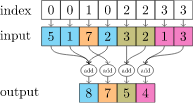

In [13]:
from torch_scatter import scatter_mean, scatter

In [19]:
src   = torch.Tensor([[2, 0, 1, 4, 3], [0, 2, 1, 3, 4]])
index = torch.tensor([[4, 5, 4, 2, 3], [0, 0, 2, 2, 1]])

# par défaut c'est la somme (scatter_add)
print(scatter(src, index))

# on peut faire la moyenne
out = src.new_zeros((2, 6))
out = scatter_mean(src, index, out=out)
print(out)

tensor([[0., 0., 4., 3., 3., 0.],
        [2., 4., 4., 0., 0., 0.]])
tensor([[0.0000, 0.0000, 4.0000, 3.0000, 1.5000, 0.0000],
        [1.0000, 4.0000, 2.0000, 0.0000, 0.0000, 0.0000]])


# DataLoaders et batches

In [15]:
from torch_geometric.loader import DataLoader

**Question** Créer des loaders nommés `{train,test}_loader`, de taille de batch 64. Il est préférable de mélanger (shuffle) les batches d'entraînement.

In [20]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

**Observation** Iterations sur les batches

In [21]:
i = iter(test_loader)
for b in i:
    print(b)

DataBatch(edge_index=[2, 8450], x=[2206, 3], y=[64], batch=[2206], ptr=[65])
DataBatch(edge_index=[2, 8128], x=[2090, 3], y=[64], batch=[2090], ptr=[65])
DataBatch(edge_index=[2, 3246], x=[814, 3], y=[22], batch=[814], ptr=[23])


On peut faire une itération juste sur le DataLoader

In [22]:
for b in test_loader:
    print(b)

DataBatch(edge_index=[2, 8450], x=[2206, 3], y=[64], batch=[2206], ptr=[65])
DataBatch(edge_index=[2, 8128], x=[2090, 3], y=[64], batch=[2090], ptr=[65])
DataBatch(edge_index=[2, 3246], x=[814, 3], y=[22], batch=[814], ptr=[23])


**Question** Regarder le premier batch du test grâce à un iterateur sur son loader. Nommez-le `batch`. Affichez ce batch et ses labels. Combien y a-t-il de noeuds, attributs dans le batch ?

In [23]:
batch = next(iter(test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:100])

Batch: DataBatch(edge_index=[2, 8450], x=[2206, 3], y=[64], batch=[2206], ptr=[65])
Labels: tensor([3, 3, 0, 1, 3, 4, 2, 5, 0, 3, 3, 0, 4, 3, 2, 2, 4, 2, 2, 0, 5, 0, 2, 5,
        5, 0, 2, 1, 0, 3, 0, 4, 5, 5, 1, 5, 2, 0, 0, 0, 3, 5, 0, 1, 0, 1, 5, 3,
        0, 3, 0, 1, 2, 4, 5, 3, 1, 1, 2, 5, 1, 3, 0, 0])


On a 64 graphes, 2206 noeuds avec 3 attributs.

Par ce moyen, tous les graphes sont concaténés. C'est un peu comme si on avait un unique grand graphe avec des composantes connexes correspondant à chaque petit graphe. L'attribut `batch` du batch donne les indices des graphes auquel ces noeuds appartiennent. 

**Question** regarder les indices des 45 premiers et 35 derniers éléments de ce `batch`.  Combien y a-t-il de noeuds dans le premier et dernier graphe de ce batch?

In [18]:
print("Indices:", batch.batch[:45])
print("Indices:", batch.batch[-35:])

Indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
Indices: tensor([62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63])


Les 44 premiers sont du premier graphe, les 33 derniers sont du dernier.

**Question** On peut alors avec scatter rassembler les données par graphe. Faire une moyenne des attributs des noeuds par batch et par graphe...

In [25]:
for batch in test_loader:
    x = scatter_mean(batch.x, batch.batch, dim=0)
    print(x,"\n")

tensor([[0.5455, 0.4545, 0.0000],
        [0.2143, 0.5000, 0.2857],
        [0.2500, 0.7500, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.6098, 0.3902, 0.0000],
        [0.6364, 0.3636, 0.0000],
        [0.8000, 0.2000, 0.0000],
        [0.5556, 0.4444, 0.0000],
        [0.6667, 0.3333, 0.0000],
        [0.5833, 0.4167, 0.0000],
        [0.2273, 0.5227, 0.2500],
        [0.2857, 0.7143, 0.0000],
        [0.6444, 0.3556, 0.0000],
        [0.3333, 0.6667, 0.0000],
        [0.3000, 0.7000, 0.0000],
        [0.6429, 0.3571, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.3333, 0.6667, 0.0000],
        [0.4800, 0.5200, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.6250, 0.3750, 0.0000],
        [0.2917, 0.7083, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.5238, 0.4762, 0.0000],
        [0.7500, 0.2500, 0.0000],
        [0.2727, 0.7273, 0.0000],
        [0.5294, 0.4706, 0.0000],
        [0.4516, 0.5484, 0.0000],
        [0.7917, 0.2083, 0.0000],
        [0.550

# Masques de train et de test

Ils peuvent être dans la définition de l'objet Data. Regardons avec Planetoid.

**Question** Lire le jeu de données Cora dans Planetoid et regardez les caractéristiques (cf questions plus haut)

In [26]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [27]:
print("nombre de graphes : ", len(dataset),
      "\nnombre de classes : ", dataset.num_classes,
     "\nnombre d'attributs de noeuds", dataset.num_node_features)

nombre de graphes :  1 
nombre de classes :  7 
nombre d'attributs de noeuds 1433


Il n'y a qu'un graphe dans ce jeu de données.

**Question** Regardez les caractéristiques des graphes de ce jeu de données et vérifier qu'il y a bien un masque pour train, dev, et test.

In [28]:
data = dataset[0]

In [29]:
print("nb noeuds : ", data.num_nodes ,
      "\nnb arêtes : ", data.num_edges, 
      "\nnb attributs noeuds :", data.num_node_features, 
      "\nnb attributs arêtes :", data.num_edge_features,
      "\nnoeuds isolés :", data.has_isolated_nodes(),
      "\nself loops :", data.has_self_loops(), "\ndirigé :",data.is_directed())

nb noeuds :  2708 
nb arêtes :  10556 
nb attributs noeuds : 1433 
nb attributs arêtes : 0 
noeuds isolés : False 
self loops : False 
dirigé : False


In [30]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

**Question** Combien y a-t-il de noeuds dans les masques de test, train, et val ? Existe-t-il des noeuds qui ne sont dans aucun de ces masques ? 

Il y a 140 noeuds dans l'ensemble d'apprentissage, 500 en validation et 1000 en test. Cela ne donne pas les 2708... 

In [31]:
data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item()

(140, 500, 1000)

In [32]:
all_masks = data.train_mask + data.test_mask + data.val_mask

In [34]:
(all_masks == False).sum().item()

1068

In [36]:
140+500+1000+1068

2708

# Transformations à la lecture

On peut appliquer des transformations à la lecture du jeu de données

In [37]:
import torch_geometric.transforms as T

In [38]:
from torch_geometric.datasets import Planetoid

dataset_norm = Planetoid(root='/tmp/Cora2', name='Cora', transform=T.NormalizeFeatures())

Processing...
Done!


In [39]:
dataset[0].x.sum(axis=1)

tensor([ 9., 23., 19.,  ..., 18., 14., 13.])

In [40]:
dataset_norm[0].x.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])